In [34]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [37]:
def simulation(y_grid, e_grid, h_grid, g_grid, θ=1.86/1000.,
               y_start=.5394, T=100, dt=1):
    Et = np.zeros(int(T/dt)+1)
    yt = np.zeros(int(T/dt)+1)
    ht = np.zeros(int(T/dt)+1)
    gt = np.zeros((len(g_grid), int(T/dt)+1))
    for i in range(int(T/dt)+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ht[i] = np.interp(y_start, y_grid, h_grid)
        for n in range(gt.shape[0]):
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ*dt
    return Et, yt, ht, gt

## Solve HJB

In [2]:
# Intensity parameter
τ = .25

r1 = 19.5001
r0 = .4

# Robustness parameters
ξ_b = 100000.
ξ_p = 5.
ξ_a = 1./100

n_model = 40
damage_setting={'γ_2p': np.linspace(0, 1./3, n_model),
                'πd_o': np.ones(n_model)/n_model}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.5

# Grid setting
ϵ = 2.
y_step = .02
y_grid_long = np.arange(0., y_bar_upper*2+y_step, y_step)
y_grid_short = np.arange(0., y_bar_upper+y_step, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
y_grid_tilde = y_grid_short[y_bar_lower_loc: y_bar_upper_loc+1]

In [3]:
# Parallelly solve ODE
model_args_list = []
model_list = []

for i in range(n_model):
    temp_list = []
    for y_jump in y_grid_tilde:
        temp = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_a, γ_1, γ_2, γ_2p[i], y_jump)
        temp_list.append((y_grid_long, temp, None, ϵ, 1e-8, 2000, False))
    model_args_list.append(temp_list)

for i in range(n_model):
    print('-----Solving model ' + str(i) + '-----')
    temp_res = ode_y_parallel(model_args_list[i])
    model_list.append(temp_res)

-----Solving model 0-----
-----Solving model 1-----
-----Solving model 2-----
-----Solving model 3-----
-----Solving model 4-----
-----Solving model 5-----
-----Solving model 6-----
-----Solving model 7-----
-----Solving model 8-----
-----Solving model 9-----
-----Solving model 10-----
-----Solving model 11-----
-----Solving model 12-----
-----Solving model 13-----
-----Solving model 14-----
-----Solving model 15-----
-----Solving model 16-----
-----Solving model 17-----
-----Solving model 18-----
-----Solving model 19-----
-----Solving model 20-----
-----Solving model 21-----
-----Solving model 22-----
-----Solving model 23-----
-----Solving model 24-----
-----Solving model 25-----
-----Solving model 26-----
-----Solving model 27-----
-----Solving model 28-----
-----Solving model 29-----
-----Solving model 30-----
-----Solving model 31-----
-----Solving model 32-----
-----Solving model 33-----
-----Solving model 34-----
-----Solving model 35-----
-----Solving model 36-----
-----Solvin

In [4]:
# Prepare ϕ_m
ϕ_m = np.zeros((n_model, len(y_grid_short)))
e_m = np.zeros((n_model, len(y_grid_short)))
for i in range(len(y_grid_tilde)):
    for j in range(n_model):
        ϕ_m[j, y_bar_lower_loc+i] = model_list[j][i]['v0'][y_bar_lower_loc+i]
        e_m[j, y_bar_lower_loc+i] = model_list[j][i]['e_tilde'][y_bar_lower_loc+i]

# Prepare v_guess
v_guess = np.average(np.array([model_list[0][-1]['v0'][:y_bar_upper_loc+1],
                               model_list[-1][-1]['v0'][:y_bar_upper_loc+1]]),
                     weights=np.array([0.5, 0.5]), axis=0)

In [5]:
np.max(ϕ_m)

4.604324101228557

In [103]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, τ = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = - η * (y_grid + y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = - r0 * (np.exp(- r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)
#     intensity = 0.75 * (y_grid - 1.5) * (y_grid > 1.5) + 300 * (y_grid - 1.9)**2 * (y_grid > 1.9)

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5
 
        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

#         g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

#         A = np.ones_like(y_grid)*(-δ)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0)- np.exp(-1./ξ_2m * v0)) \
#                 / np.exp(-1./ξ_2m * v0)


        g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

        A = np.ones_like(y_grid)*(-δ)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            + intensity * np.sum(g * πd_o * (ϕ_m - v0), axis=0)\
            + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)



#         g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

#         A = np.ones_like(y_grid)*(-δ) - intensity * np.sum(πd_o * g, axis=0)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)\
#             + intensity * np.sum(πd_o * g * ϕ_i, axis=0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, 0), (False, False))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o
    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [104]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, τ)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=1,
                                          tol=1e-8, max_iter=1000, print_all=True)

Iteration 1: LHS Error: 0.71916921349876; RHS Error 0.7195984122505565
Iteration 2: LHS Error: 0.42328086191046466; RHS Error 0.4252161942583595
Iteration 3: LHS Error: 0.2950976758266415; RHS Error 0.2980669748693693
Iteration 4: LHS Error: 0.22707851819421299; RHS Error 0.23052200536563028
Iteration 5: LHS Error: 0.18513723995050801; RHS Error 0.18916496863775273
Iteration 6: LHS Error: 0.1575381688444617; RHS Error 0.16145981277993784
Iteration 7: LHS Error: 0.137715107157532; RHS Error 0.1419560169562233
Iteration 8: LHS Error: 0.12338641050480326; RHS Error 0.12721703534610693
Iteration 9: LHS Error: 0.11181726617281385; RHS Error 0.11553748700515398
Iteration 10: LHS Error: 0.10285597916234179; RHS Error 0.1067803949771351
Iteration 11: LHS Error: 0.09521040372564338; RHS Error 0.099229652367611
Iteration 12: LHS Error: 0.08943626688055062; RHS Error 0.09289058398508028
Iteration 13: LHS Error: 0.08379071401397553; RHS Error 0.08808656324017285
Iteration 14: LHS Error: 0.07953618

Iteration 121: LHS Error: 0.012922477522720577; RHS Error 0.012362192487782926
Iteration 122: LHS Error: 0.012767803555528534; RHS Error 0.012208896400717976
Iteration 123: LHS Error: 0.012606369960087349; RHS Error 0.012064147636119099
Iteration 124: LHS Error: 0.012458545769600704; RHS Error 0.011917685446866007
Iteration 125: LHS Error: 0.012302074928156603; RHS Error 0.011773759015246528
Iteration 126: LHS Error: 0.012157333740157483; RHS Error 0.011634308378650454
Iteration 127: LHS Error: 0.012008246376989273; RHS Error 0.011490589165366279
Iteration 128: LHS Error: 0.011863397995368619; RHS Error 0.011357666705842942
Iteration 129: LHS Error: 0.011721703676718764; RHS Error 0.011218583715689644
Iteration 130: LHS Error: 0.01157619001428678; RHS Error 0.01108760036385447
Iteration 131: LHS Error: 0.011441609648488615; RHS Error 0.010955385184705763
Iteration 132: LHS Error: 0.011301956935416246; RHS Error 0.01082347234247364
Iteration 133: LHS Error: 0.01116750367110031; RHS Erro

Iteration 259: LHS Error: 4.511768354889534e-05; RHS Error 0.003744082864900248
Iteration 260: LHS Error: 4.4840056923511895e-05; RHS Error 0.003744053217909115
Iteration 261: LHS Error: 4.523645080833916e-05; RHS Error 0.0037436041812108946
Iteration 262: LHS Error: 4.5016386132412656e-05; RHS Error 0.003743601599356435
Iteration 263: LHS Error: 4.533134841983033e-05; RHS Error 0.0037431767691194877
Iteration 264: LHS Error: 4.515719899714221e-05; RHS Error 0.0037432053486372054
Iteration 265: LHS Error: 4.540742892591987e-05; RHS Error 0.0037428077300155106
Iteration 266: LHS Error: 4.526968779289264e-05; RHS Error 0.0037428674031215435
Iteration 267: LHS Error: 4.5468880171234405e-05; RHS Error 0.003742496606142568
Iteration 268: LHS Error: 4.5359793529486936e-05; RHS Error 0.003742585025677446
Iteration 269: LHS Error: 4.551915498340886e-05; RHS Error 0.0037422388528016853
Iteration 270: LHS Error: 4.543241104970619e-05; RHS Error 0.003742352632989311
Iteration 271: LHS Error: 4.55

Iteration 395: LHS Error: 5.0957844242000006e-05; RHS Error 0.0037368577922006034
Iteration 396: LHS Error: 4.00389233959908e-05; RHS Error 0.0037366106501942574
Iteration 397: LHS Error: 4.7222638864030664e-05; RHS Error 0.0037367462070663944
Iteration 398: LHS Error: 3.549820605722176e-05; RHS Error 0.00373642397140473
Iteration 399: LHS Error: 1.4372443321558626e-05; RHS Error 0.003736442838506795
Iteration 400: LHS Error: 1.0816245068878683e-05; RHS Error 0.003736508786693179
Iteration 401: LHS Error: 1.0329165967604137e-05; RHS Error 0.003736590052012774
Iteration 402: LHS Error: 5.087496529893043e-05; RHS Error 0.0037368827446307464
Iteration 403: LHS Error: 4.0040883310499265e-05; RHS Error 0.003736634487870292
Iteration 404: LHS Error: 4.720231228708127e-05; RHS Error 0.003736768565316847
Iteration 405: LHS Error: 3.549799219487726e-05; RHS Error 0.0037364451815916425
Iteration 406: LHS Error: 1.4377961215727986e-05; RHS Error 0.00373646285877308
Iteration 407: LHS Error: 1.081

Iteration 533: LHS Error: 1.0856872147135821e-05; RHS Error 0.003736503512752936
Iteration 534: LHS Error: 1.0429499926245533e-05; RHS Error 0.003736581186472354
Iteration 535: LHS Error: 5.110678830566595e-05; RHS Error 0.003736871978159608
Iteration 536: LHS Error: 4.007313609469265e-05; RHS Error 0.003736620270037832
Iteration 537: LHS Error: 4.7281200956289515e-05; RHS Error 0.003736752591757507
Iteration 538: LHS Error: 3.554203776934273e-05; RHS Error 0.00373642621772749
Iteration 539: LHS Error: 1.4387227653234191e-05; RHS Error 0.0037364412217315707
Iteration 540: LHS Error: 1.0856695620065082e-05; RHS Error 0.0037365035179351795
Iteration 541: LHS Error: 1.0429068759920668e-05; RHS Error 0.003736581208025381
Iteration 542: LHS Error: 5.1105816704560825e-05; RHS Error 0.0037368720089809883
Iteration 543: LHS Error: 4.007299280914256e-05; RHS Error 0.003736620316657755
Iteration 544: LHS Error: 4.728086597707848e-05; RHS Error 0.0037367526469819987
Iteration 545: LHS Error: 3.55

Iteration 676: LHS Error: 4.007264947811229e-05; RHS Error 0.003736621318040839
Iteration 677: LHS Error: 4.72791707311071e-05; RHS Error 0.003736753615669334
Iteration 678: LHS Error: 3.5541274019640356e-05; RHS Error 0.0037364272491338217
Iteration 679: LHS Error: 1.4387244324315374e-05; RHS Error 0.0037364422555296144
Iteration 680: LHS Error: 1.0856037892470471e-05; RHS Error 0.003736504551627929
Iteration 681: LHS Error: 1.0426973888921776e-05; RHS Error 0.003736582242454621
Iteration 682: LHS Error: 5.11001025425839e-05; RHS Error 0.003736873004519005
Iteration 683: LHS Error: 4.007265136798943e-05; RHS Error 0.003736621311041761
Iteration 684: LHS Error: 4.7279181301318474e-05; RHS Error 0.0037367536089718614
Iteration 685: LHS Error: 3.554127709270993e-05; RHS Error 0.0037364272425738053
Iteration 686: LHS Error: 1.438724380359302e-05; RHS Error 0.003736442249118177
Iteration 687: LHS Error: 1.0856040519979793e-05; RHS Error 0.0037365045453698342
Iteration 688: LHS Error: 1.042

Iteration 811: LHS Error: 3.5541277336986754e-05; RHS Error 0.0037364272306689705
Iteration 812: LHS Error: 1.4387240973273707e-05; RHS Error 0.0037364422380117314
Iteration 813: LHS Error: 1.0856039848072818e-05; RHS Error 0.0037365045350366173
Iteration 814: LHS Error: 1.0426986237099811e-05; RHS Error 0.003736582226744195
Iteration 815: LHS Error: 5.11001463054106e-05; RHS Error 0.0037368729899572156
Iteration 816: LHS Error: 4.007265005162575e-05; RHS Error 0.003736621297339031
Iteration 817: LHS Error: 4.727919203983966e-05; RHS Error 0.003736753596254201
Iteration 818: LHS Error: 3.554127701851928e-05; RHS Error 0.0037364272306731824
Iteration 819: LHS Error: 1.4387240920454847e-05; RHS Error 0.003736442238014913
Iteration 820: LHS Error: 1.0856039978190957e-05; RHS Error 0.00373650453504025
Iteration 821: LHS Error: 1.0426986280342998e-05; RHS Error 0.00373658222675086
Iteration 822: LHS Error: 5.110014617923375e-05; RHS Error 0.0037368729899675025
Iteration 823: LHS Error: 4.00

Iteration 937: LHS Error: 3.554127748023328e-05; RHS Error 0.003736427230424933
Iteration 938: LHS Error: 1.4387240940522128e-05; RHS Error 0.003736442237766785
Iteration 939: LHS Error: 1.0856040126960842e-05; RHS Error 0.003736504534791029
Iteration 940: LHS Error: 1.0426987165079726e-05; RHS Error 0.003736582226496931
Iteration 941: LHS Error: 5.110014814249664e-05; RHS Error 0.003736872989722955
Iteration 942: LHS Error: 4.0072650314249e-05; RHS Error 0.0037366212971034034
Iteration 943: LHS Error: 4.7279192669252845e-05; RHS Error 0.0037367535960277504
Iteration 944: LHS Error: 3.554127752841696e-05; RHS Error 0.0037364272304435675
Iteration 945: LHS Error: 1.4387241006663665e-05; RHS Error 0.0037364422377839067
Iteration 946: LHS Error: 1.0856040162265934e-05; RHS Error 0.0037365045348060795
Iteration 947: LHS Error: 1.0426987031353363e-05; RHS Error 0.003736582226509879
Iteration 948: LHS Error: 5.1100148172500415e-05; RHS Error 0.003736872989730869
Iteration 949: LHS Error: 4.0

## Simulation

In [98]:
e_grid_no_jump = model_res['e_tilde']
e_grid_jump_list = []
for i in range(n_model):
    temp = np.array([model['e_tilde'] for model in model_list[i]])
    e_grid_jump_list.append(temp)
e_grid_jump = np.array(e_grid_jump_list)

In [99]:
# def simulation_prob(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
#                         θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, γ_2p, n_model, T=100):
#     """
#     y_grid : (N,) ndarray
#     e_grid_no_jump : (N,) ndarray
#     e_grid_jump : (n_model, M, N) ndarray
#         e.g., e_grid[0, i], e_grid[1, i] and e_grid[2, i] are the emissions conditional
#             on low, high and extreme damages when jump occurrs at y_grid_tilde[i].
#     """
#     record_t = []
#     for i in range(T+1):
#         e_states = []
#         y_states = []
#         y_tilde_states = [] # -1 if no jump occurred
#         γ_2p_states = [] # -1 if no jump occurred
#         states_prob = []
        
#         if y0 < y_bar_lower:
#             e0 = np.interp(y0, y_grid_long, e_grid_no_jump)
#             y0 = y0 + e0 * θ
#             e_states.append(e)
#             y_states.append(y)
#             y_tilde_states.append(-1)
#             γ_2p_states.append(-1)
#             states_prob.append(1)
#         else:
#             intensity = - r0 * (np.exp(- r1 / 2. * (y0-y_bar_lower)**2) - 1.)
#             jump_prob = τ * intensity
            
        
#         for j, y0 in enumerate(y0_states):
#             if γ_2p_states[j] == -1:
                
                
                
                
#             if y0 <= y_bar_lower:
#                 y0 = y0 + et[i] * θ
            
    
    
#     yt = np.zeros(T+1)
#     et = np.zeros(T+1)
#     damage_states_t = np.zeros(T+1)
#     jump_occurred = False
#     e_grid_realized = e_grid_no_jump
#     for i in range(T+1):
#         if y0 > y_bar_lower and jump_occurred == False:
#             intensity = - r0 * (np.exp(- r1 / 2. * (y0-y_bar_lower)**2) - 1.)
#             jump_prob = τ * intensity
#             realized_jump_state = np.random.multinomial(n=1, pvals=np.array([jump_prob, 1-jump_prob]))
#             if np.array_equal(realized_jump_state, np.array([1, 0])) or y0 > y_bar_upper:
#                 jump_occurred = True
#                 realized_damage_state = np.random.multinomial(n=1, pvals=damage_prob)
#                 loc = find_nearest_value(y_grid_tilde, y0)
#                 for i in range(n_model):
#                     temp = np.zeros(n_model)
#                     temp[i] = 1
#                     if np.array_equal(realized_damage_state, temp):
#                         e_grid_realized = e_grid_jump[i, loc]
#                         damage_states_t[i:] = i + 1
#         if jump_occurred:
#             et[i] = np.interp(y0, y_grid_long, e_grid_realized)
#         else:
#             et[i] = np.interp(y0, y_grid_short, e_grid_realized)
#         yt[i] = y0
#         y0 = y0 + et[i]*θ
#     return et, yt, damage_states_t

In [100]:
@njit
def simulation_one_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                        θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, n_model, T=100):
    """
    y_grid : (N,) ndarray
    e_grid_no_jump : (N,) ndarray
    e_grid_jump : (n_model, M, N) ndarray
        e.g., e_grid[0, i], e_grid[1, i] and e_grid[2, i] are the emissions conditional
            on low, high and extreme damages when jump occurrs at y_grid_tilde[i].
    """
    yt = np.zeros(int(T/τ)+1)
    et = np.zeros(int(T/τ)+1)
    damage_states_t = np.zeros(int(T/τ)+1)
    jump_occurred = False
    e_grid_realized = e_grid_no_jump
    for i in range(int(T/τ)+1):
        if y0 > y_bar_lower and jump_occurred == False:
#             intensity = - r0 * (np.exp(- r1 / 2. * (y0-y_bar_lower)**2) - 1.)
            intensity = 0.75 * (y_grid - 1.5) * (y_grid > 1.5) + 300 * (y_grid - 1.9)**2 * (y_grid > 1.9)
            jump_prob = τ * intensity
            realized_jump_state = np.random.multinomial(n=1, pvals=np.array([jump_prob, 1-jump_prob]))
            if np.array_equal(realized_jump_state, np.array([1, 0])) or y0 > y_bar_upper:
                jump_occurred = True
                realized_damage_state = np.random.multinomial(n=1, pvals=damage_prob)
                loc = find_nearest_value(y_grid_tilde, y0)
                for i in range(n_model):
                    temp = np.zeros(n_model)
                    temp[i] = 1
                    if np.array_equal(realized_damage_state, temp):
                        e_grid_realized = e_grid_jump[i, loc]
                        damage_states_t[i:] = i + 1
        if jump_occurred:
            et[i] = np.interp(y0, y_grid_long, e_grid_realized)
        else:
            et[i] = np.interp(y0, y_grid_short, e_grid_realized)
        yt[i] = y0
        y0 = y0 + et[i]*θ
    return et, yt, damage_states_t

@njit
def simulation_n_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                      θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, n_model, T=80, N=10_000):
    yt_n_path = np.zeros((N, int(T/τ)+1))
    et_n_path = np.zeros((N, int(T/τ)+1))
    damage_states_t_n_path = np.zeros((N, int(T/τ)+1))
    for n in range(N):
        et, yt, damage_states_t = simulation_one_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                                     θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, n_model=n_model, T=T)
        yt_n_path[n] = yt
        et_n_path[n] = et
        damage_states_t_n_path[n] = damage_states_t
    return et_n_path, yt_n_path, damage_states_t_n_path

In [14]:
et, yt, damage_states_t = simulation_n_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                           np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, y_bar_upper=y_bar_upper, r0=r0,
                           r1=r1, τ=τ, damage_prob=damage_setting['πd_o'], n_model=n_model, T=120, N=1_000_000)

## No jump plots

In [105]:
T = 91
et_no_jump, yt_no_jump, _, _ = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=T, dt=τ)
time_periods = np.arange(0, T+τ, τ)

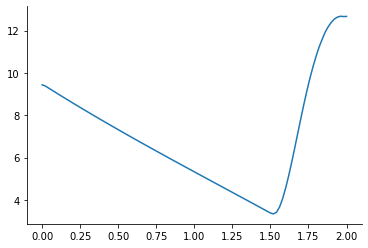

In [106]:
plt.plot(model_res['y_grid'], e_grid_no_jump)

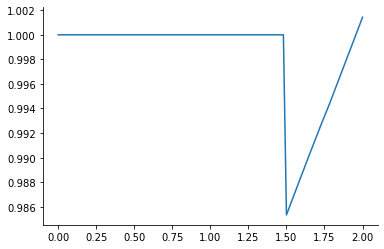

In [75]:
plt.plot(model_res['y_grid'], np.average(np.exp(-1./ξ_p*ϕ_m), weights=πd_o, axis=0))

In [76]:
yt_no_jump.shape

(365,)

In [77]:
# Compute no jump probability
no_jump_prob = np.ones_like(yt_no_jump)
for t in range(no_jump_prob.shape[0]):
    y = yt_no_jump[t]
    if y > y_bar_lower:
#         intensity = - r0 * (np.exp(- r1 / 2. * (y-y_bar_lower)**2) - 1.)
        intensity = 0.75 * (y - 1.5) * (y > 1.5)\
                    + 300 * (y - 1.9)**2 * (y > 1.9)
        no_jump_prob[t] = (1 - intensity*τ) * no_jump_prob[t-1]

In [78]:
# np.save('yt_03.npy', yt_no_jump)
# np.save('prob_03.npy', no_jump_prob)

(0.0, 1.05)

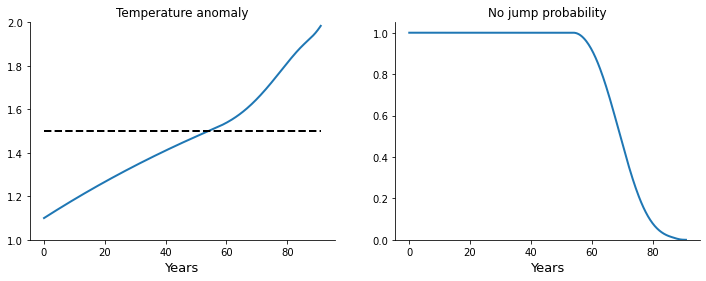

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(time_periods, yt_no_jump, linewidth=2.)
ax1.plot(time_periods, np.ones_like(yt_no_jump)*1.5, linestyle='dashed', color='black', linewidth=2)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_title(r'Temperature anomaly')
ax1.set_ylim(1, 2)

ax2.plot(time_periods, no_jump_prob, linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_title(r'No jump probability')
ax2.set_ylim(0, 1.05)

# fig.savefig('fig.pdf')

In [81]:
no_jump_prob[-1]

1.899304037968837e-05

In [82]:
yt_no_jump[-1]

1.9838842770478293

In [87]:
def compute_prob(array):
    array_unique = np.unique(array)
    prob = np.zeros_like(array_unique)
    for i, point in enumerate(array_unique):
        prob[i] = np.sum(array==point)/len(array)
    return array_unique, prob

## Histograms

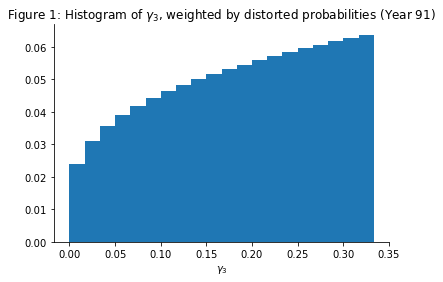

In [85]:
# Implied distorted probabilities
T_plot_new = 91
yt_loc = find_nearest_value(model_res['y_grid'], yt_no_jump[int(T_plot_new/τ)])

Gt_m = model_res['g'][:, yt_loc]
πd = Gt_m*πd_o / np.sum(Gt_m*πd_o)
plt.hist(γ_2p, weights=πd, bins=20)
plt.xlabel(r'$\gamma_3$')
plt.title(r'Figure 1: Histogram of $\gamma_3$, weighted by distorted probabilities (Year ' + str(T_plot_new) + ')')
plt.savefig('fig_1.pdf')

In [90]:
# Compute probabilities
T_plot = 120
et_states, et_prob = compute_prob(et[:, int(T_plot/τ)])
yt_states, yt_prob = compute_prob(yt[:, int(T_plot/τ)])

In [91]:
# Compute probabilities
T_plot_new = 90
et_states_new, et_prob_new = compute_prob(et[:, T_plot_new])
yt_states_new, yt_prob_new = compute_prob(yt[:, T_plot_new])

In [ ]:
plt.figure()
plt.hist(et_states, weights=et_prob, bins=20)
plt.title('Figure 1: Histogram of emission, Year 120')

plt.figure()
plt.hist(et_states_new, weights=et_prob_new, bins=20)
plt.title('Figure 2: Histogram of emission, Year 90')

In [ ]:
yt_states_new

In [ ]:
plt.figure()
plt.hist(yt_states, weights=yt_prob, bins=20)
plt.title('Figure 1: Histogram of temperature anomaly, Year 120')

plt.figure()
plt.hist(yt_states_new, weights=et_prob_new, bins=20)
plt.title('Figure 2: Histogram of temperature anomaly, Year 90')